In [ ]:
'''
    - NLTK -- for tokenezing russian texts of election programs
    
    - (LINK!!) -- for creating matrix of program_x_term
    - sklearn -- for clustering...
'''

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# 1. Loading data - election programs and flags of candidates

In [2]:
# downloading all election programs

programs_df = pd.read_csv('../library: main/ssmm_elections_candidates_1_11.csv', sep='\t', encoding='utf-8')
programs_df = programs_df[['conv_x_name','name','program_txt','convocation_no']][programs_df['program_txt'].notna()].reset_index().drop(['index'],axis=1)
programs_df.head()


,conv_x_name,name,program_txt,convocation_no
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1
1,1_Кириллова_Полина,Кириллова Полина,Мне нравится заниматься общественной деятельно...,1
2,1_Семенов_Павел,Семенов Павел,"""Здравствуйте. Я так понимаю, что я уже поздно...",1
3,1_Кузнецова_Алёна,Кузнецова Алёна,"""Меня очень интересует жизнь Университета. я б...",1
4,1_Кунденко_Вадим,Кунденко Вадим,""" Добрый день! Пару слов о себе. Путь к мехм...",1


In [3]:
# downloading info about first nomination/membership of person

core_df = pd.read_csv('../library: main/ssmm_candidates_core.csv', sep='\t', encoding='utf-8')
# print(list(core_df))
core_df = core_df[['name','min_member_conv_no','min_cand_conv_no','cand_conv_cnt','manage_convocation_cnt']].reset_index().drop(['index'],axis=1)
core_df = core_df.fillna(0)
core_df.head()


,name,min_member_conv_no,min_cand_conv_no,cand_conv_cnt,manage_convocation_cnt
0,Владыкина Вероника Евгеньевна,1.0,1,3,2.0
1,Коновалов Антон Александрович,1.0,1,2,1.0
2,Ласкин Алексей Александрович,1.0,1,3,0.0
3,Малхасян Арамаис,1.0,1,1,0.0
4,Попов Леонид Андреевич,1.0,1,3,2.0


In [4]:
# downloanding info about person's cluster (after clustering of person)

person_clusters_df = pd.read_csv('person_clusters.csv', sep='\t', encoding='utf-8')
person_clusters_df = person_clusters_df[['key','cluster']].rename(columns={'key':'name'})
person_clusters_df.head()

,name,cluster
0,Владыкина Вероника Евгеньевна,4
1,Коновалов Антон Александрович,1
2,Ласкин Алексей Александрович,1
3,Малхасян Арамаис,2
4,Попов Леонид Андреевич,4


In [5]:
programs_df_2 = programs_df.merge(core_df, on='name', how='left')
# print(list(programs_df_2))

# new flag (I'm interested in: True / False)
programs_df_2['first_nomination_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_cand_conv_no']
# new flag (I'm interested in: False)
programs_df_2['first_membership_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_member_conv_no']

programs_df_2 = programs_df_2.merge(person_clusters_df, on='name', how='left')
programs_df_2.head(1)

,conv_x_name,name,program_txt,convocation_no,min_member_conv_no,min_cand_conv_no,cand_conv_cnt,manage_convocation_cnt,first_nomination_flg,first_membership_flg,cluster
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1,1.0,1,1,0.0,True,True,2


In [6]:
len(programs_df_2)

481

In [8]:
# pd.set_option('display.max_colwidth', None)

In [12]:
# downloading info about candidates with election programs

# programs_df = pd.read_csv('../library: main/ssmm_elections_candidates_1_11.csv', sep='\t', encoding='utf-8')
# programs_df = programs_df[['conv_x_name','program_txt','convocation_no']][programs_df['program_txt'].notna()].reset_index().drop(['index'],axis=1)

# programs_df.head()


In [13]:
# len(programs_df)

In [37]:
# defining a dataset of programs for clustering


# all nominations
programs_df_3 = programs_df_2[list(programs_df_2)] # bad clustering

# only 1st nomination
# programs_df_3 = programs_df_2[programs_df_2['first_nomination_flg'] == True] 

# 2+ ordinal number of nomination
# programs_df_3 = programs_df_2[programs_df_2['first_nomination_flg'] == False] 
# bad clustering of 2-grams, even there are no 2-grams with 'мероприят'

# only persons from clusters 1,2,4
# programs_df_3 = programs_df_2[programs_df_2['cluster'].isin([1,2,4])] # bad clustering

# programs_df_3 = programs_df_2[programs_df_2['cluster'] == 4] # bad clustering
# programs_df_3 = programs_df_2[programs_df_2['cand_conv_cnt'] >= 3] # worse clustering
# programs_df_3 = programs_df_2[programs_df_2['cand_conv_cnt'] >= 4] # bad clustering
# programs_df_3 = programs_df_2[programs_df_2['convocation_no'].isin([4,5,6])] # bad clustering

len(programs_df_3)

481

In [38]:
# to find n-th occurance of substring in the string (n = 0,1...)
def find_substring(txt, str1, n):
    parts = txt.split(str1, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(txt) - len(parts[-1]) - len(str1)

programs_df_3['short_key'] = programs_df_3['conv_x_name'].apply(lambda x: x[:find_substring(x, '_', 1)+2])


# limit = 91 # for convocations 1-3
limit = len(programs_df_3)
key_program_list = list(programs_df_3['short_key'])[:limit]
program_list = list(programs_df_3['program_txt'])[:limit]

# number of processing programs 
len(program_list)

481

# 2. Tokenizing of texts

In [9]:
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
# for russian text

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')
# stopwords

# Stemming is just the process of breaking a word down into its root.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:

# def remove_noise(text, stop_words = []):
#     tokens = word_tokenize(text, language="russian")
#     cleaned_tokens = []
#     for token in tokens:
#         token = re.sub('[^А-Яа-я]+', '', token)
#         if len(token) > 1 and token.lower() not in stop_words:
#             # Get lowercase
#             cleaned_tokens.append(token.lower())
#     return cleaned_tokens

# [^A-Za-z0-9]+

# remove_noise("Мне нравится заниматься общественной деятельностью.")

In [ ]:
# http://brandonrose.org/clustering#Stopwords,-stemming,-and-tokenizing

In [83]:
# to add stopwords

# stopwords += [
#         'это', 'этим', 
#         'моего',
#         'свой', 'свои', 'своего', 'своей', 
#         'всем', 'всё',
#         'нашего', 
#         'таких', 'также', 
#         'поэтому', 'многие', 'очень', 'других', 
#         'который', 'которая', 'которое', 'которого', 'которую', 'которым', 'которой', 'которых'
#     ] + [
#         'являюсь', 
#         'хотел', 'хотела', 'хочу', 'хотелось',
#         'могу',
#         'рассказ', 'школе', 
#         'году', 'год', 'года',
#         'зовут', 'привет', 'различных', 'надеюсь', 'считаю', 'просто', 'вообще'
#     ] + [
#         'мгу', 'университет', 'университета',
# #         'мехмата', 'мехмат', 'мехмате', 'факультета', 'факультете', 'факультет',
#         'студсовета', 'студсовете', 'студсовет', 'совет', 'совета', 'совете',
#         'студентов', 'студенты', 'студентам', 'студенческий', 'студенческого', 'студенческом',
#         '2012',
#         'организации', 'организацией', 'организация'
#       ]


In [40]:
# sents = nltk.sent_tokenize('Мне нравится заниматься общественной деятельностью, всячески пытаюсь расширять свой кругозор. Еще в школе организовывала различные мероприятия и была сильно этим заинтересована', language="russian")
# print(sents)

# for sent in sents:
#     for word in nltk.word_tokenize(sent, language="russian"):
#         print(word)


In [10]:
#

def tokenize_and_stem(text, stopwords=stopwords, lang="russian"):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text, stopwords, lang):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens



In [43]:
# for program in program_list:
#     print(tokenize_and_stem(program, stopwords, "russian"))

In [39]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in program_list:
    allwords_stemmed = tokenize_and_stem(i, stopwords, "russian")
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i, stopwords, "russian")
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(vocab_frame.shape[0])

25655


# 3. Tf-idf and program similarity

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer


## 3.0 Predefined functions

In [13]:
from scipy.cluster.vq import kmeans #, vq

def elbow_plot(tfidf_matrix):
    distortions = []
    num_clusters_range = range(1, 21)

    # Create a list of distortions from the kmeans method
    for i in num_clusters_range:
        cluster_centers, distortion = kmeans(tfidf_matrix.todense(), i)
        distortions.append(distortion) 

    # Create a DataFrame with two lists - number of clusters and distortions
    elbow_plot = pd.DataFrame({'num_clusters': num_clusters_range,
                               'distortions': distortions})
    # Creat a line plot of num_clusters and distortions
    sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
    plt.xticks(num_clusters_range)
    plt.show()
    
    return 1

In [14]:
from sklearn.cluster import KMeans

def create_clusters(tfidf_matrix, num_clusters, key_list, content_list):

    km = KMeans(n_clusters=num_clusters, n_init=10)
    %time km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    program_clusters = {
        'key': key_list, 
        'content': content_list, 
        'cluster': clusters
    }
    frame = pd.DataFrame(program_clusters, index = [clusters], columns = ['key', 'content', 'cluster'])
    print(frame['cluster'].value_counts())
    
    return km, frame

In [15]:
def print_clusters(km, frame, terms, num_clusters):
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    print("Top terms per cluster:")
    print()
    
    cluster_dict = {}
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i) # , end=''

        for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
            if km.cluster_centers_[i][ind] > 0:
                print("{0} - {1:.3f}".format(terms[ind], km.cluster_centers_[i][ind]))
        print()

        print("Cluster %d keys:" % i) # , end=''
        for key in frame.loc[i]['key'].values.tolist():
            print('%s,\t\t' % key, end='') # JUST FOR conv_x_name !!!
            cluster_dict[key] = i
        print()
        print()

#     print(cluster_dict)
    
    return pd.DataFrame.from_dict(cluster_dict, orient='index').rename(columns={0:'cluster'})

In [16]:
from scipy import sparse

def delete_noise(tfidf_matrix, terms, drop_n_grams):
#     print(terms)
    search = np.array(drop_n_grams)
#     print(search)
    search_indexes = np.searchsorted(terms, np.intersect1d(terms, search))
#     print(search_indexes)
    terms = np.delete(terms, search_indexes)

    # deleting these columns from tfidf_matrix    
    indexes_to_keep = list(set(range(tfidf_matrix.shape[1]))-set(search_indexes))
    tfidf_matrix = sparse.lil_matrix(sparse.csr_matrix(tfidf_matrix)[:, indexes_to_keep]) # tfidf_matrix_new

    # to see the result
    # tfidf_array_new = tfidf_matrix.todense()
    # tfidf_df = pd.DataFrame(tfidf_array_new)
    # tfidf_df
    
    return tfidf_matrix, terms

## 3.1 Clustering of programs (the beginning)


In [134]:
# alternative way, with own list of stop words
# https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn

tfidf_vectorizer = TfidfVectorizer(
#     max_features=200, 
    max_df=0.7, min_df=0.01, # 0.020 for 400 programs
    ngram_range=(2,2), # only 2-grams
    tokenizer=tokenize_and_stem, 
    stop_words=stopwords
)

tfidf_matrix = tfidf_vectorizer.fit_transform(program_list)
# idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
terms = tfidf_vectorizer.get_feature_names_out()

print(tfidf_matrix.shape)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(481, 361)


In [135]:
# terms

In [136]:
# tfidf_matrix

In [137]:
# most frequent 2-grams
# terms

In [138]:
# deleting noise

drop_2_grams = [
#     greetings and requests
    'буд рад', 'ваш поддержк', 'добр ден', 'добр времен', 'времен суток', 'пода заявк', 'спасиб вниман', 'стат член', 'ваш голос', 
    
#     about theirself
    'избира вперв', 'избира втор', 'избира трет', 'избира четверт', 'предыдущ созыв', 'прошл созыв', 'нов созыв', 'мо программ', 
    'перв курс', 'студент курс', 'старост групп', 'ваш интерес', 'поток курс', 
    
#     common phrases
#     'вмест сдела', 'внест вклад', 'возможн помоч', 'продолж работ', 'занима вопрос', 'продолж занима', 'сдела жизн', 'дела жизн', 
#     'созыв планир', 'планир заня', 
#     'планир занима', 'планир продолж', 'активн занима', 'активн участ', 'активн участвова', 'активн участник', 
#     'помога студсовет', 'постара сдела', 'принима активн', 'принима участ', 'приня участ', 'участ жизн', 
#     'обществен деятельн', 'обществен жизн', 'занима обществен', 'наш жизн', 'студенческ жизн', 'жизн мехматя', 'сдела наш', 
#     'лучш вуз', 'вуз стран', 'нов ид', 
#     'план работ', 'работ групп', 'рабоч групп', 'нов проект', 'студенческ совет', 'групп занима', 
    
#     other
    'вопрос котор', 'котор будут', 'огромн количеств', 'дан момент', 'ближайш врем', 'ден ден', 'мероприят котор', 'проект котор', 
    'котор будут', 'бур эмоц', 'учебн част', 'кажд ден', 'кажд студент', 'младш курс', 'связ студент', 'вещ котор', 'втор раз.', 
    'люд котор', 'мног друг', 'что-т нов', 'что-т полезн', 

]

tfidf_matrix, terms = delete_noise(tfidf_matrix, terms, drop_2_grams)


## 3.2 Clustering of 2-grams

There are many 2-grams with similar meaning which can be distributed by different clusters.
So firstly I will cluster 2-grams and create modified tf-idf matrix for programs.

In [139]:
grams_df = pd.DataFrame(terms).rename(columns={0: '2_gram'})
grams_df

,2_gram
0,активн занима
1,активн участ
2,активн участв
3,активн участвова
4,активн участник
...,...
322,эт направлен
323,эт сдела
324,явля куратор
325,явля член


In [154]:
grams_df[300:]

,2_gram
300,хотел работа
301,хотел сдела
302,хотел участвова
303,хоч вступ
304,хоч занима
305,хоч помога
306,хоч помоч
307,хоч попробова
308,хоч приня
309,хоч продолж


In [155]:
fixed_grams_df = grams_df[list(grams_df)]
fixed_grams_df['2_gram_cluster'] = None

grams_dict = {
    'cultmass': ['мероприят', 'праздник', 'пифагор', 'дня мехмат', 'дня', 'ден мехмат', 'ноч мехмат', 'конкурс групп', 'школ актив', 
                 'организатор', 'посв', 'культурно-массов'],
    'infrastructure': ['бытов', 'общежит', 'главн здан', 'иногородн', 'переход', 'макулатур', 'туалет', 'проживан'],
    'education': ['образован', 'учебн процесс', 'куратор', 'встреч второкурсник', 'иностра язык', 'встреч кафедр', 
                  'групп первокурсник', 'опрос качеств'],
    'informing': ['оповещен', 'информирован'],
    'sport': ['спортивн'],
    'grants': ['повышен', 'стипенд', 'распределен'],
    'partners': ['партнер'],
    'rights': ['инициативн групп', 'защища', 'прав студент', 'представля', 'самоуправлен', 'студсовет мгу']
}

for k in grams_dict.keys():
    fixed_grams_df.loc[fixed_grams_df['2_gram'].str.contains('|'.join(grams_dict[k])), '2_gram_cluster'] = k

# fixed_grams_df = fixed_grams_df.fillna('other')

fixed_grams_df[fixed_grams_df['2_gram_cluster'].notna()].groupby(['2_gram_cluster']).size()
# fixed_grams_df[fixed_grams_df['2_gram_cluster'].isna()][80:]


2_gram_cluster
cultmass          34
education         12
grants             5
informing          3
infrastructure    12
partners           1
rights             7
sport              2
dtype: int64

In [156]:
tfidf_array_new = tfidf_matrix.todense()
tfidf_array_new = pd.DataFrame(tfidf_array_new)
tfidf_array_new_2 = pd.concat([tfidf_array_new.T,fixed_grams_df], axis=1)
tfidf_array_new_3 = tfidf_array_new_2[tfidf_array_new_2['2_gram_cluster'].notna()]
tfidf_array_new_3

,0,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,2_gram,2_gram_cluster
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.498035,0.0,0.0,0.0,0.0,0.0,0.0,бытов вопрос,infrastructure
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,вопрос образован,education
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,встреч второкурсник,education
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,встреч кафедр,education
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311084,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,главн здан,infrastructure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,участ мероприят,cultmass
288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,участвова распределен,grants
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,учебн процесс,education
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.425036,0.0,0.0,0.0,0.0,0.0,0.0,школ актив,cultmass


In [157]:
tfidf_array_new_4 = tfidf_array_new_3.groupby('2_gram_cluster')\
                            .agg({i: 'sum' for i in range(len(list(tfidf_array_new_3))-2)})
tfidf_array_new_4


,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
2_gram_cluster,,,,,,,,,,,,,,,,,,,,,
cultmass,0.591883,0.417134,0.0,0.383158,0.0,0.000000,0.0,0.000000,0.0,0.284222,...,0.0,0.0,0.0,0.425036,0.0,0.0,0.0,0.0,0.0,0.0
education,0.000000,0.000000,0.0,0.000000,0.0,0.272104,0.0,0.281581,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
grants,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.123588,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
informing,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
infrastructure,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.605553,0.0,0.951192,...,0.0,0.0,0.0,0.981340,0.0,0.0,0.0,0.0,0.0,0.0
partners,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
rights,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.527474,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
sport,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
tfidf_array_new_5 = tfidf_array_new_4.T
tfidf_array_new_5

2_gram_cluster,cultmass,education,grants,informing,infrastructure,partners,rights,sport
0,0.591883,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.417134,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.383158,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
476,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
479,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
import scipy

In [159]:
tfidf_matrix_fixed = scipy.sparse.csr_matrix(tfidf_array_new_5.values)
tfidf_matrix_fixed

<481x8 sparse matrix of type '<class 'numpy.float64'>'
	with 472 stored elements in Compressed Sparse Row format>

In [160]:
terms_fixed = np.array(list(tfidf_array_new_5))
terms_fixed

array(['cultmass', 'education', 'grants', 'informing', 'infrastructure',
       'partners', 'rights', 'sport'], dtype='<U14')

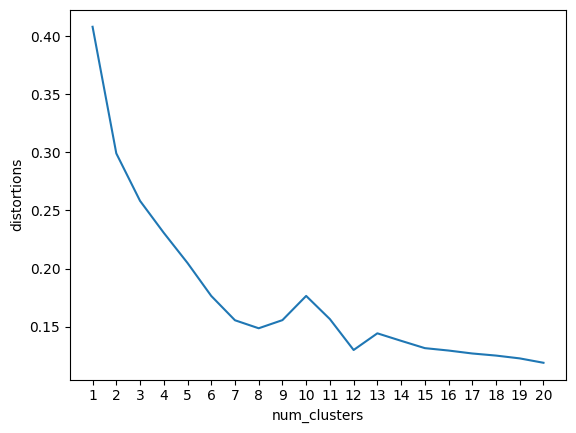

1

In [132]:
elbow_plot(tfidf_matrix_fixed)

In [162]:
num_clusters_fixed = 8

km_fixed, frame_fixed = create_clusters(tfidf_matrix_fixed, num_clusters_fixed, key_program_list, program_list)
program_cluster_df = print_clusters(km_fixed, frame_fixed, terms_fixed, num_clusters_fixed)
program_cluster_df

CPU times: user 124 ms, sys: 100 ms, total: 224 ms
Wall time: 51.7 ms
0    217
2     96
7     38
1     37
5     37
3     29
6     21
4      6
Name: cluster, dtype: int64
Top terms per cluster:

Cluster 0 words:
sport - 0.020
cultmass - 0.014
informing - 0.009
grants - 0.008
infrastructure - 0.007
rights - 0.002
education - 0.002

Cluster 0 keys:
1_Семенов_П,		1_Кунденко_В,		1_Глухова_А,		1_Попов_Л,		1_Артамонова_М,		1_Чернодед_А,		1_Савушкин_Н,		2_Остроухова_Н,		2_Габидов_А,		2_Дяченко_М,		2_Ватутин_К,		2_Багров_К,		2_Лавров_В,		2_Оджаев_Р,		3_Бурнус_А,		3_Денисов_И,		3_Суркова_А,		3_Корно_Д,		3_Изимова_А,		3_Ариас-Альварес_В,		3_Дорман_Е,		3_Глунчадзе_И,		3_Матвеев_Д,		3_Хасанов_Р,		3_Скопинцев_А,		3_Селиверстова_Е,		3_Антонова_О,		3_Сергеева_Э,		3_Ласкин_А,		3_Короткин_В,		4_Суркова_А,		4_Бунеев_А,		4_Антонов_С,		4_Мылзенова_Д,		4_Нечаев_Н,		4_Яшин_Р,		4_Змиевский_Л,		4_Ахмеджанова_М,		4_Аседова_Е,		4_Шведов_К,		4_Бахметьева_М,		4_Оджаев_Р,		4_Лапина_С,		4_Коварский_А,		4_Лучкина_А,	

,cluster
1_Семенов_П,0
1_Кунденко_В,0
1_Глухова_А,0
1_Попов_Л,0
1_Артамонова_М,0
...,...
11_Лоншаков_Н,7
11_Зенков_Т,7
11_Вербовская_Д,7
11_Витковский_А,7


In [43]:
# creating lists for clustrinf of 2-grams
grams_df = pd.DataFrame(terms).rename(columns={0: '2_gram'})
key_grams_list = list(grams_df['2_gram'])
grams_list = list(grams_df['2_gram'])

# tf-idf model for 2-grams
tfidf_vectorizer_grams = TfidfVectorizer(
#     max_features=200, 
    max_df=0.7, min_df=0.01, 
    ngram_range=(1,1), # only 1-grams
    tokenizer=tokenize_and_stem, 
    stop_words=stopwords
)

tfidf_matrix_grams = tfidf_vectorizer_grams.fit_transform(grams_list)
# idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
terms_grams = tfidf_vectorizer_grams.get_feature_names_out()

print(tfidf_matrix_grams.shape)

(96, 77)


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
# deleting noise

drop_1_grams = [
    'групп', 'жизн', 'курс', 'работ', 'планир', 'соз', 'студенческ', 'студент', 'заним', 'привет',
    'котор', 'нов', 'сдел', 'участ', 'продолж', 'активн', 'деятельн', 'организац',
    'хоч', 'хотел', 'эт', 'студсовет', 'наш', 'сво', 'такж', 'год', 'факультет', 'обществ', 'оч', 'участвов', 'вступ', 'помог',
    'мехмат', 'поэт', 'интерес', 'университет', 'ид', 'зан', 'совет', 'обуч', 'член', '', ''
]

tfidf_matrix_grams, terms_grams = delete_noise(tfidf_matrix_grams, terms_grams, drop_1_grams)


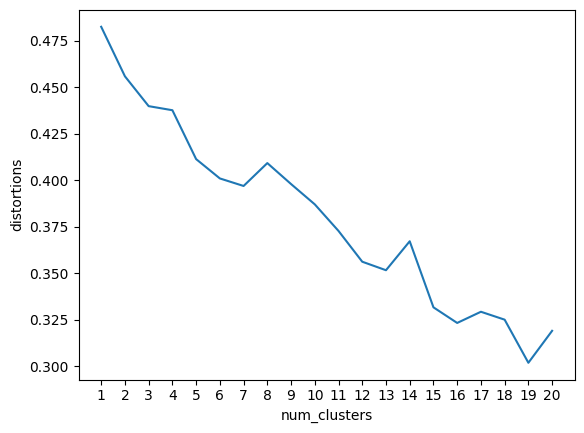

1

In [45]:
elbow_plot(tfidf_matrix_grams)

In [46]:
num_clusters_grams = 13

km_grams, frame_grams = create_clusters(tfidf_matrix_grams, num_clusters_grams, key_grams_list, grams_list)
print_clusters(km_grams, frame_grams, terms_grams, num_clusters_grams)


CPU times: user 148 ms, sys: 119 ms, total: 267 ms
Wall time: 62.2 ms
0     69
3      5
5      3
7      2
9      2
6      2
10     2
8      2
2      2
1      2
12     2
4      2
11     1
Name: cluster, dtype: int64
Top terms per cluster:

Cluster 0 words:
праздник - 0.024
выбор - 0.012
состо - 0.012
дня - 0.012
образова - 0.012
куратор - 0.012
конкурс - 0.012
оповещ - 0.012
партнер - 0.012
план - 0.012

Cluster 0 keys:
активн участ,		активн участвова,		бытов вопрос,		всем привет,		вступ студсовет,		выбор студсовет,		год планир,		групп образован,		групп оповещен,		групп праздник,		групп студсовет,		деятельн студсовет,		дня мехмат,		жизн мехмат,		жизн наш,		жизн студент,		жизн университет,		жизн факультет,		занима обществен,		занима организац,		иностра язык,		интерес студент,		конкурс групп,		куратор групп,		мехмат такж,		наш университет,		наш факультет,		нов проект,		обществен деятельн,		обществен жизн,		организац праздник,		план работ,		планир занима,		планир продолж,		повышен стипенд,

,cluster
активн участ,0
активн участвова,0
бытов вопрос,0
всем привет,0
вступ студсовет,0
...,...
наш поток,10
сво поток,10
распределен повышен,11
принима активн,12


In [322]:
# to find 2-grams with given word

foo = 'мероприят'

arr = np.array([np.char.find(t, foo) for t in terms])
# np.place(arr, arr > -1, True)
# np.place(arr, arr == -1, False)
# # arr

# indexes = np.where(arr == 1)
indexes = np.where(arr != -1)

indexes

(array([ 7, 12, 30, 33, 34]),)

# Create an elbow plot

In [192]:
from scipy.cluster.vq import kmeans #, vq

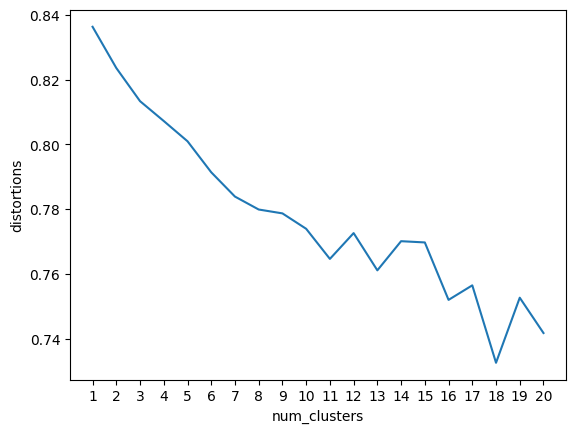

1

In [405]:
elbow_plot(tfidf_matrix)

In [ ]:
# VERY LOW DISTORTION!!!! 
# for
# only persons from clusters 1,2,4

# K-Means clusters

In [209]:
from sklearn.cluster import KMeans

In [369]:
num_clusters = 9

km, frame = create_clusters(tfidf_matrix, num_clusters, key_program_list, program_list)
print_clusters(km, frame, terms, num_clusters)


CPU times: user 141 ms, sys: 114 ms, total: 256 ms
Wall time: 59.6 ms
0    287
8     30
3     15
7     13
6     10
4      9
2      8
5      4
1      3
Name: cluster, dtype: int64
Top terms per cluster:

Cluster 0 words:
интересн мероприят - 0.020
качеств образован - 0.020
групп помога - 0.014
участвова мероприят - 0.014
проведен мероприят - 0.014
пифагор ден - 0.014
инициативн групп - 0.013
занима праздник - 0.013
проблем котор - 0.012
сбор макулатур - 0.011

Cluster 0 keys:
		1_Левин_А,		1_Кириллова_П,		1_Кузнецова_А,		1_Сафина_Д,		1_Глухова_А,		1_Владыкина_В,		1_Сапунов_К,		1_Артамонова_М,		1_Чернодед_А,		1_Штейников_Ю,		1_Савушкин_Н,		2_Габидов_А,		2_Дяченко_М,		2_Ватутин_К,		2_Багров_К,		2_Быстрицкая_В,		2_Сафина_Д,		2_Осин_Р,		2_Смелов_В,		2_Оджаев_Р,		2_Тен_А,		2_Акушевич_А,		2_Дьяков_П,		2_Сапунов_К,		2_Абдуллаева_Э,		3_Бурнус_А,		3_Денисов_И,		3_Ариас-Альварес_В,		3_Григорьев_И,		3_Дорман_Е,		3_Локтионов_Ф,		3_Глунчадзе_И,		3_Ватутин_К,		3_Матвеев_Д,		3_Бунеев_А,		3_Борисов_В,	

1

In [110]:
tfidf_array_new = tfidf_matrix.todense()
tfidf_array_new = pd.DataFrame(tfidf_array_new)
tfidf_array_new_2

,0,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,2_gram,2_gram_cluster
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,активн участ,None
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,активн участвова,None
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.515678,0.000000,0.0,0.0,0.0,0.0,0.0,бытов вопрос,быт
3,0.0,0.38884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.41161,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,внест сво,None
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.323185,0.0,0.0,1.0,0.0,0.0,всем привет,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395022,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,член студсовет,None
142,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.440093,0.000000,0.0,0.0,0.0,0.0,0.0,школ актив,культ-масс
143,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237998,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,эт вопрос,None
144,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,эт врем,None


# ======== DRAFTS:
# ======== DRAFTS:
# ======== DRAFTS:

## Analysis of most frequent tokens

In [42]:
# first index (row) = serial number of program
# second index (column) = serial number of feature (1-token)

# print(tfidf_matrix)

In [85]:
tfidf_array = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.649005,0.0,0.433823,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.449875,0.000000,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.269096,0.225922,...,0.170960,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.251177,0.0
3,0.310085,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.281636,0.0,0.377678,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.320848,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.444809,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.000000,0.0,0.0,0.399021,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.351444,0.000000,0.0,0.000000,0.0,0.0,0.0,0.553184,0.000000,0.0
161,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
162,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
163,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


In [118]:
# tfidf_df[search_indexes]

In [165]:
# flags of occurance 
tfidf_flags_df = tfidf_df[list(tfidf_df)]
for col in list(tfidf_df):
    tfidf_flags_df[col] = np.sign(tfidf_flags_df[col])
# tfidf_flags_df

# frequency of features
feature_frequency = pd.DataFrame(np.sum(tfidf_flags_df)).rename(columns={0:'count'})
# feature_frequency

# russian words of features
terms_df = pd.DataFrame(terms).rename(columns={0:'token'})
# terms_df

# Top-20 of most frequent tokens
tfidf_feature_df = pd.concat([feature_frequency, terms_df], axis=1).sort_values(by='count', ascending=False)
tfidf_feature_df.head(20)

,count,token
30,43.0,повышен стипенд
9,32.0,ден пифагор
0,27.0,активн участ
25,22.0,обществен деятельн
4,22.0,групп образован
7,19.0,групп праздник
5,17.0,групп оповещен
19,16.0,конкурс групп
14,16.0,занима обществен
20,15.0,координатор рабоч


In [226]:
# exceptions = ['групп','вопрос','участ','нов','врем','созыв','перв','студент','поток','студенческ','член','наш','ваш','ид','втор']

# tfidf_feature_df[~tfidf_feature_df['token'].isin(exceptions)].head(30)

In [32]:
# tfidf_matrix.todense()

In [53]:
# terms

In [ ]:
# GOOD ENOUGH: 
# 1-3 conv [:91] 
# max_features=100
# max_df=0.2, min_df=0.05
# num_clusters = 3


In [175]:
# km.cluster_centers_

In [176]:
# km.cluster_centers_.argsort()

# (Alt: Clustering with sparse matrix)

In [224]:
from scipy.cluster.vq import kmeans, vq

In [225]:
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:10])

['конкурс групп', 'обществен деятельн', 'бытов вопрос', 'планир занима', 'вопрос котор', 'активн участ', 'дня пифагор', 'жизн мехматя', 'занима вопрос', 'инициативн групп']
['инициативн групп', 'внест вклад', 'иностра язык', 'планир продолж', 'координатор рабоч', 'обществен жизн', 'активн участ', 'дела жизн', 'занима вопрос', 'общежит гз']
['обществен работ', 'активн участ', 'добр ден', 'общежит гз', 'групп оповещен', 'интерес поток', 'нов созыв', 'иностра язык', 'дела жизн', 'групп образован']
['ответствен секретар', 'активн участ', 'интересн мероприят', 'перв курс', 'активн участник', 'нов проект', 'интерес поток', 'групп первокурсник', 'мероприят ден', 'наш жизн']
['групп оповещен', 'встреч второкурсник', 'жизн интересн', 'занима обществен', 'качеств образован', 'групп образован', 'лучш вуз', 'повышен стипенд', 'куратор групп', 'жизн мехматя']


In [ ]:
# CONCLUSION: clustering is failed
# (maybe because of noisy words)

In [356]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
# print
# print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [357]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [366]:
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# cluster_names = {0: 'Family, home, war', 
#                  1: 'Police, killed, murders', 
#                  2: 'Father, New York, brothers', 
#                  3: 'Dance, singing, love', 
#                  4: 'Killed, soldiers, captain'}

cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = str(i)

In [445]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=key_list)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], # color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

ValueError: All arrays must be of the same length

In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=100, stop_words='english')

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(speech_df['text_clean'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
print(tv_df.head())

In [ ]:
# N-grams !!!!

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate a trigram vectorizer
cv_trigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range=(3,3))

# Fit and apply trigram vectorizer
cv_trigram = cv_trigram_vec.fit_transform(speech_df['text_clean'])

# Print the trigram features
print(cv_trigram_vec.get_feature_names())

# Create a DataFrame of the features
cv_tri_df = pd.DataFrame(cv_trigram.toarray(), 
                 columns=cv_trigram_vec.get_feature_names()).add_prefix('Counts_')

# Print the top 5 words in the sorted output
print(cv_tri_df.sum().sort_values(ascending=False).head())

# ideas from datacamp

In [ ]:
# NAIVE BAYES -- the best classifier for texts

# Import the necessary modules
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Training and testing the "fake news" model with CountVectorizer

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)


In [ ]:
# Training and testing the "fake news" model with TfidfVectorizer

# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)


In [ ]:
# basic features:
#     - number of words
#     - number of charachters
#     - average length of words

#     - number of sentences
#     - number of paragraphs
#     - number of words starting with capitals


# text features
# word features

# Create a feature char_count
tweets['char_count'] = tweets['content'].apply(len)

# Print the average character count
print(tweets['char_count'].mean())

In [ ]:
# Function that returns number of words in a string
def count_words(string):
	# Split the string into words
    words = string.split()
    
    # Return the number of words
    return len(words)

# Create a new feature word_count
ted['word_count'] = ted['transcript'].apply(count_words)

# Print the average word count of the talks
print(ted['word_count'].mean())

In [ ]:
# lemmatization = convert words into its base form

# Function to preprocess text
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)
  
# Apply preprocess to ted['transcript']
ted['transcript'] = ted['transcript'].apply(preprocess)
print(ted['transcript'])

In [ ]:
# part-of-speech (POS) tagging


In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words='english')

# Fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# Print shape of X_train_bow and X_test_bow
print(X_train_bow.shape)
print(X_test_bow.shape)

In [ ]:
# Create a MultinomialNB object
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Measure the accuracy
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was terrible. The music was underwhelming and the acting mediocre."
prediction = clf.predict(vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

In [ ]:
# n-grams

In [ ]:
# Generate n-grams upto n=1
vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))
ng1 = vectorizer_ng1.fit_transform(corpus)

# Generate n-grams upto n=2
vectorizer_ng2 = CountVectorizer(ngram_range=(1,2))
ng2 = vectorizer_ng2.fit_transform(corpus)

# Generate n-grams upto n=3
vectorizer_ng3 = CountVectorizer(ngram_range=(1, 3))
ng3 = vectorizer_ng3.fit_transform(corpus)

# Print the number of features for each model
print("ng1, ng2 and ng3 have %i, %i and %i features respectively" % (ng1.shape[1], ng2.shape[1], ng3.shape[1]))

In [ ]:
# Define an instance of MultinomialNB 
clf_ng = MultinomialNB()

# Fit the classifier 
clf_ng.fit(X_train_ng, y_train)

# Measure the accuracy 
accuracy = clf_ng.score(X_test_ng, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was not good. The plot had several holes and the acting lacked panache."
prediction = clf_ng.predict(ng_vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

In [ ]:
start_time = time.time()
# Splitting the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(df['review'], df['sentiment'], test_size=0.5, random_state=42, stratify=df['sentiment'])

# Generating ngrams
vectorizer = CountVectorizer(ngram_range=(1,3))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# Fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram representation had %i features." % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

In [ ]:
'''
(?)
    - to predict by program length, in what time the candidate nominates
    - to classify programs by quantitative features 
'''

In [ ]:
'''
QUESTIONS:
    - is clustering working on stemmed_words, not on original?
    - how to cut the top of noisy words?

IDEAS:
    - to cluster programs for 1st nomination and for 2+ nominations (+, but no sense)
    - to cluster programs for clusters of persons !!!
    - to add 2-tokens
    
    - to cluster programs only for 3+ time nominated persons
    - to unite text of each person with 2+ time nominated persons?
    
    - TO ADD VISUALIZATION (scatterplot) !!!!!
'''